In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
import re
import datetime
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

### Описание датасета.

Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

 - Restaurant_id — идентификационный номер ресторана / сети ресторанов;                                                         
 - City — город, в котором находится ресторан;
 - Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
 - Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
 - Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
 - Price Range — диапазон цен в ресторане;
 - Number of Reviews — количество отзывов о ресторане;
 - Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
 - URL_TA — URL страницы ресторана на TripAdvosor;
 - ID_TA — идентификатор ресторана в базе данных TripAdvisor.

# Загрузка Pandas и очистка данных

In [2]:
#  Загрузим датасеты

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4]:
df.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


 Пропущенные значения  имеются в 4 столбцах 'Cuisine Style'(25%), 'Price Range'(35%), 'Number of Reviews'(7%) и 'Reviews'(2шт).

In [6]:
df.describe()

,Ranking,Number of Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


In [7]:
#Посмотрим на название колонок
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

##  Обработка NAN

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком!
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак



In [8]:
df['number_of_reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['price_range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['reviews_isNAN'] = pd.isna(df['Reviews']).astype('uint8')

In [9]:
# Изменим пропущенные значения в столбце 'Cuisine Style' на 'unknown'
# Превратим значения в столбце 'Cuisine Style' в списки
df['Cuisine Style'] = df['Cuisine Style'].fillna("['unknown_style']")
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: ast.literal_eval(x))

In [10]:
# Заменим отсутствующие значения отзывов на 0.
df['Number of Reviews'].fillna(0, inplace=True)

In [11]:
df['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

~2/3 известных значений в средней ценовой категории

In [12]:
# Заменим отссутствующие значения на '$$ - $$$?'
df['Price Range'].fillna('$$ - $$$', inplace = True)

## Обработка признаков

Для начала посмотрим какие признаки у нас могут быть категориальными.

In [13]:
# Посмотрим на количество кухонь
pd.DataFrame(df['Cuisine Style'].tolist()).stack().value_counts()

Vegetarian Friendly    14021
European               12561
unknown_style          11590
Mediterranean           7820
Italian                 7433
                       ...  
Polynesian                 2
Xinjiang                   1
Salvadoran                 1
Burmese                    1
Latvian                    1
Length: 126, dtype: int64

In [14]:
# Создадим функцию для пребразования типа кухни ресторана в dummy-переменные

def cuisine_dummy(cell, style):
    if style[1:-1] in cell:
        return 1
    else:
        return 0

In [15]:
# Создадим список кухонь
cuisine_list = pd.DataFrame(df['Cuisine Style'].tolist()).stack().unique()

# Создадим dummy-переменные типов кухни
for style in cuisine_list:
    df[style[1:-1]] = df['Cuisine Style'].apply(cuisine_dummy, style = style)

In [16]:
# Посморим на колонку городов
df.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [17]:
# Создадим dummy-переменные городов
df_citys = pd.get_dummies(df.City)
df = pd.concat([df,df_citys], axis=1)

По описанию 'Price Range' это - Цены в ресторане.
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [18]:
price_dict = {'$$ - $$$':2,'$':1, '$$$$':3}
df['Price Range'].replace(to_replace=price_dict, inplace=True)

## EDA

Exploratory Data Analysis - Анализ данных На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками. В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой. Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

Посмотрим распределение признака

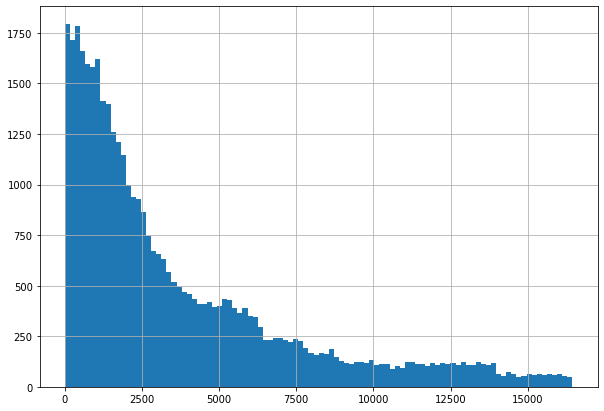

In [19]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

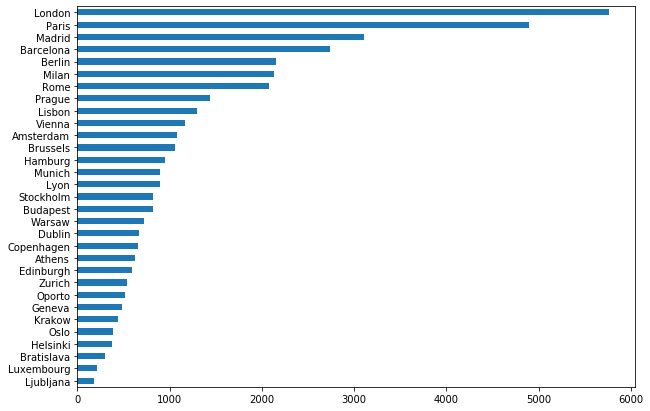

In [20]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Посмотрим распределение целевой переменной

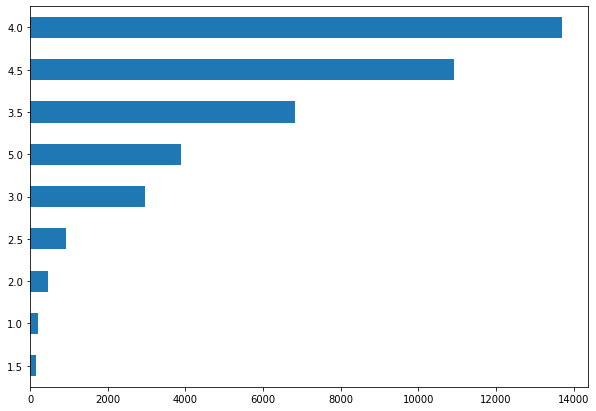

In [21]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Посмотрим распределение целевой переменной относительно признака

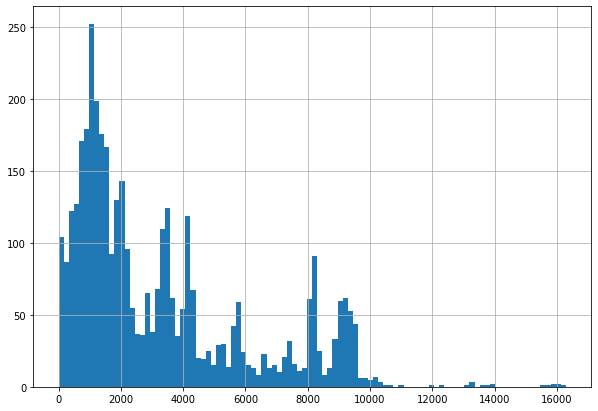

In [22]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

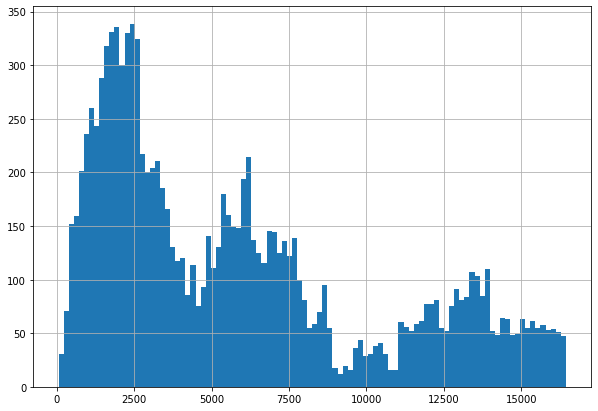

In [23]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Корреляция признаков

In [24]:
# Посмотриим на столбец "Reviews"
df['Reviews'].fillna('[[],[]]' , inplace = True)
df['Reviews'].value_counts()[:10]

[[], []]                                                                                                             8112
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]            2
[['Delicious'], ['06/06/2017']]                                                                                         2
[['Good service and clean', 'Chinese fusion cuisine - ok to try if you...'], ['11/21/2017', '05/23/2017']]              2
[['Good restaurant for one meal.', 'Olive Garden Restaurant Warsaw. Food very...'], ['04/20/2015', '07/15/2013']]       2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                       2
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]                                       2
[['Great Food! Wide Variety.', 'Dinner'], ['11/26/2017', '05/23/2017']]                                                 2
[['Excellent food food',

'Reveiws' состоит из отзывав и дат. На первом месте стоит из дат стоит последний отзыв

In [25]:
# Превратим строки  столбца в список
df['Reviews'] = df['Reviews'].apply( lambda x: x.replace("[[", "").replace("]]", "") .split('], ['))


In [26]:
# Создадим датафрейм с датами отзывов
Time_reviews = pd.DataFrame()
Time_reviews = df['Reviews'].apply(lambda x: x[-1].split(','))

In [27]:
Time_reviews

0                                   []
1        ['12/05/2017',  '10/29/2017']
2        ['12/28/2017',  '12/06/2017']
3        ['12/06/2017',  '11/22/2017']
4        ['02/08/2018',  '01/24/2018']
                     ...              
49995    ['12/16/2017',  '11/12/2017']
49996    ['12/21/2017',  '12/12/2017']
49997    ['11/03/2016',  '04/12/2008']
49998    ['07/11/2017',  '06/18/2017']
49999    ['01/31/2016',  '07/04/2012']
Name: Reviews, Length: 50000, dtype: object

In [28]:
# Добавим колонку с последней датой отзыва
df['Time_last_review'] = Time_reviews.apply(lambda x: x[0][1:-1])

# Добавим в список дат нулевое значение для пропусков
for i in range(0, len(df['Time_last_review'])):
    if df['Time_last_review'][i]=='':
        df['Time_last_review'][i]= 'NaN'
    elif len(Time_reviews[i]) == 1:
        Time_reviews[i] = [Time_reviews[i][0], 'NaN']
        
# Преобразуем в формат timestamp
df['Time_last_review'] = pd.to_datetime(df['Time_last_review'], errors= 'coerce', format ='%m/%d/%Y')


C:\IT\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [29]:
# Создадим series с предпоследними датами отзывов
no_last_review = Time_reviews
for i in range(0, len(Time_reviews)):
    if len(Time_reviews[i]) == 2:
        no_last_review[i]= Time_reviews[i][1][2:-1]
    else:
        no_last_review[i] = 'NaN'

# Преоразуем в формат timestamp
df['no_last_review'] = no_last_review
df['no_last_review'] = pd.to_datetime(df['no_last_review'], errors= 'coerce', format ='%m/%d/%Y')

In [30]:
#Добавим колонки 'Delta_last_review' и 'Delta_reviews'
df['Delta_last_review'] = datetime.datetime.today()-df['Time_last_review']
df['Delta_reviews'] = df['Time_last_review']-df['no_last_review']
df.Delta_reviews = df.Delta_reviews.apply(lambda x: x.days)
df.Delta_last_review = df.Delta_last_review.apply(lambda x: x.days)


In [31]:
# Заполним пропуски средними значениями
df.Delta_last_review.fillna(df.Delta_last_review.mean(), inplace=True)
df.Delta_reviews.fillna(df.Delta_reviews.mean(), inplace=True)

In [32]:
df.fillna(0, inplace=True)

In [33]:
df.describe()

,Ranking,Price Range,Number of Reviews,sample,Rating,number_of_reviews_isNAN,price_range_isNAN,reviews_isNAN,a,u,uropea,candinavia,luten Free Option,egetarian Friendl,egan Option,talia,editerranea,eafoo,renc,af,ast Foo,ortugues,nknown_styl,ree,zec,astern Europea,entral Europea,izz,ritis,panis,orwegia,frica,orocca,iddle Easter,ala,ndia,ha,utc,els,merica,teakhous,oup,cottis,usio,treet Foo,ungaria,sia,ine Ba,arbecu,entral America,eruvia,outh America,ris,olis,ietnames,ebanes,urkis,ealth,apanes,ush,ustria,hines,anis,nternationa,astropu,orea,erma,ontemporar,rabi,ine,wis,wedis,ersia,ustralia,ril,exica,ati,elgia,rgentinea,unisia,ussia,epal,angladesh,olombia,ri Lanka,akistan,rew Pu,srael,razilia,elicatesse,oshe,thiopia,aiwanes,ndonesia,alaysia,enezuela,alt,rmenia,lovenia,aribbea,amaica,cuadorea,hilea,awaiia,inority Chines,roatia,ambodia,fghan,ibeta,omania,outhwester,ongolia,ajun & Creol,ingaporea,ilipin,uba,ative America,anadia,gyptia,zerbaijan,eorgia,unna,ew Zealan,krainia,lbania,entral Asia,olynesia,aucasia,zbe,alvadora,injian,urmes,ujia,atvia,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Delta_last_review,Delta_reviews
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3664.427520,1.879320,116.505040,0.800000,3.194430,0.064000,0.347220,0.000040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027440,0.01552,0.067900,0.054100,0.007600,0.026280,0.020420,0.016380,0.016720,0.014900,0.011800,0.023720,0.009500,0.011080,0.032940,0.004440,0.143860,0.005260,0.022520,0.076260,0.053880,0.022900,0.012840,0.00976,0.122160,0.036320,0.051780,0.020660,0.028860,0.018500,0.013700,1212.746264,124.730790
std,3700.092452,0.421189,286.173104,0.400004,1.705453,0.244755,0.476091,0.006324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

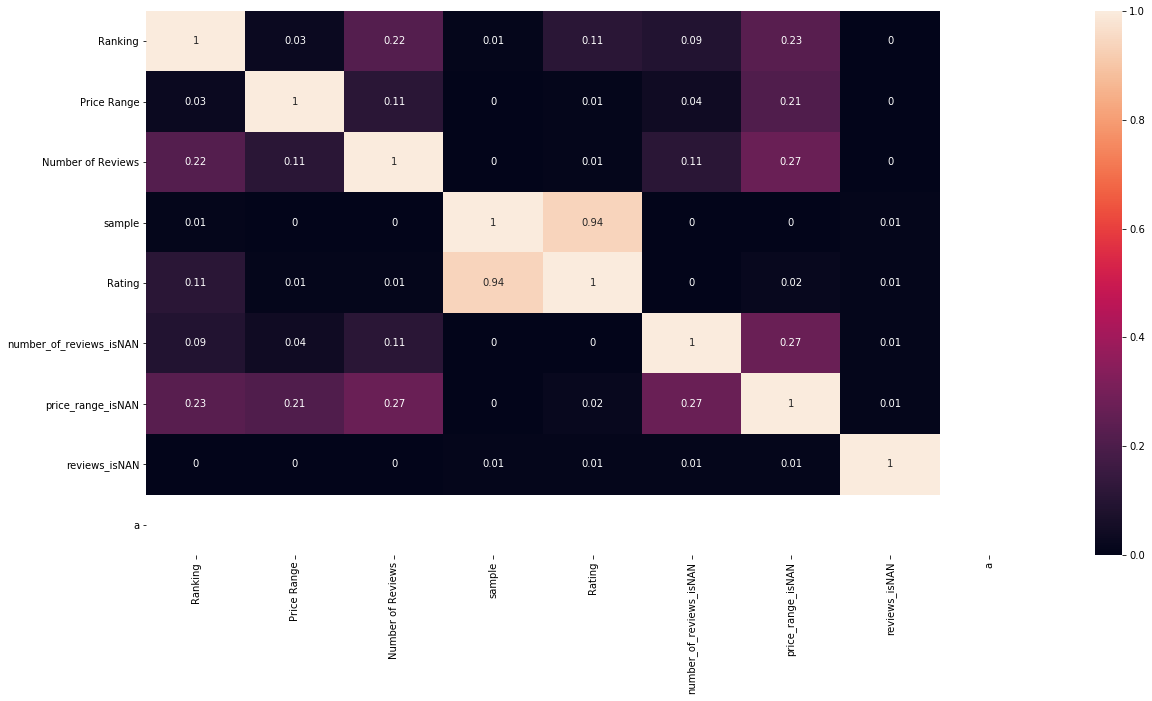

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(df[df.columns[:15]].corr().abs().round(2), annot=True)

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [35]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

In [36]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = train_data.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'Rating', 'Time_last_review', 'no_last_review'], axis = 1)
y = train_data['Rating']

In [37]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
std = StandardScaler()
col_names = ['Ranking','Price Range','Number of Reviews', 'Delta_last_review', 'Delta_reviews']
std.fit(X_train.loc[:,col_names])
X_train.loc[:,col_names] = std.transform(X_train.loc[:,col_names])
X_test.loc[:,col_names] = std.transform(X_test.loc[:,col_names])

C:\IT\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\IT\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Создаём, обучаем и тестируем модель

In [39]:
X_train.shape

(30000, 165)

In [40]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, n_jobs=20)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [41]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20863400000000001


## Submission

In [42]:
test_data.sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Rating,number_of_reviews_isNAN,price_range_isNAN,reviews_isNAN,a,u,uropea,candinavia,luten Free Option,egetarian Friendl,egan Option,talia,editerranea,eafoo,renc,af,ast Foo,ortugues,nknown_styl,ree,zec,astern Europea,entral Europea,izz,ritis,panis,orwegia,frica,orocca,iddle Easter,ala,ndia,ha,utc,els,merica,teakhous,oup,cottis,usio,treet Foo,ungaria,sia,ine Ba,arbecu,entral America,eruvia,outh America,ris,olis,ietnames,ebanes,urkis,ealth,apanes,ush,ustria,hines,anis,nternationa,astropu,orea,erma,ontemporar,rabi,ine,wis,wedis,ersia,ustralia,ril,exica,ati,elgia,rgentinea,unisia,ussia,epal,angladesh,olombia,ri Lanka,akistan,rew Pu,srael,razilia,elicatesse,oshe,thiopia,aiwanes,ndonesia,alaysia,enezuela,alt,rmenia,lovenia,aribbea,amaica,cuadorea,hilea,awaiia,inority Chines,roatia,ambodia,fghan,ibeta,omania,outhwester,ongolia,ajun & Creol,ingaporea,ilipin,uba,ative America,anadia,gyptia,zerbaijan,eorgia,unna,ew Zealan,krainia,lbania,entral Asia,olynesia,aucasia,zbe,alvadora,injian,urmes,ujia,atvia,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Time_last_review,no_last_review,Delta_last_review,Delta_reviews
9872,id_9872,London,"[Japanese, Sushi, Asian]",14320.0,2,79.0,"['Light dinner', 'Not good quality', '06/09/20...",/Restaurant_Review-g186338-d2579286-Reviews-Ko...,d2579286,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-06-09 00:00:00,2017-05-29 00:00:00,1177.000000,11.00000
6867,id_6867,Helsinki,"[Asian, Vietnamese, Vegetarian Friendly, Vegan...",122.0,1,87.0,"['Excellent authentic Asian', 'Very interestin...",/Restaurant_Review-g189934-d7594427-Reviews-Li...,d7594427,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-12-16 00:00:00,2017-11-22 00:00:00,987.000000,24.00000
2830,id_2830,Madrid,"[Mediterranean, Spanish, European]",7542.0,2,92.0,"['good location, average food', 'Nice location...",/Restaurant_Review-g187514-d1574537-Reviews-La...,d1574537,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2017-08-25 00:00:00,2017-08-22 00:00:00,1100.000000,3.00000
2893,id_2893,Barcelona,[Pizza],4455.0,1,15.0,"['pizza like to has to be', 'Perfect stop in E...",/Restaurant_Review-g187497-d6650324-Reviews-La...,d6650324,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-08-12 00:00:00,2015-06-24 00:00:00,1844.000000,49.00000
2863,id_2863,Brussels,[unknown_style],1622.0,2,25.0,"[, ]",/Restaurant_Review-g188644-d8773444-Reviews-Ta...,d8773444,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [52]:
# Создаем тестовый датасет
x_test = test_data.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA', 'Rating', 'Time_last_review', 'no_last_review'], axis = 1)

# Приводим его стандартному виду
x_test.loc[:,col_names] = std.transform(x_test.loc[:,col_names])

# Делаем предсказание
sub_pred = regr.predict(x_test)

In [53]:
# Добавляем предсзание в submission-датасет
sample_submission.Rating = sub_pred

In [54]:
# Сохраняем в формате csv
sample_submission.to_csv('sample_submission.csv', index=False)

In [55]:
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.135
1,id_1,4.265
2,id_2,4.420
3,id_3,4.305
4,id_4,4.420
5,id_5,4.295
6,id_6,2.540
7,id_7,3.030
8,id_8,4.000
9,id_9,4.600
